In [1]:
# image simulations for source reconstruction challenge
# author: Simon Birrer

### this notebook demonstrates the image simulation with the lenstronomy package

In [2]:
import numpy as np
import os
import scipy
import astropy.io.fits as pyfits
import scipy.ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline


## import image and decompose it into shapelets

In [3]:
# import astropy classes

from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
shapeletSet = ShapeletSet()
import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util



6.228
6637


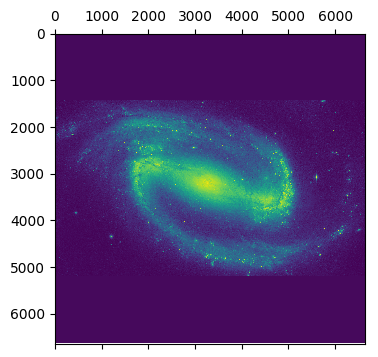

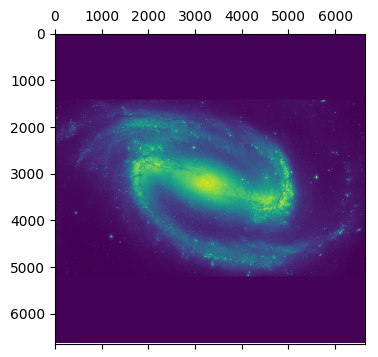

265
-12


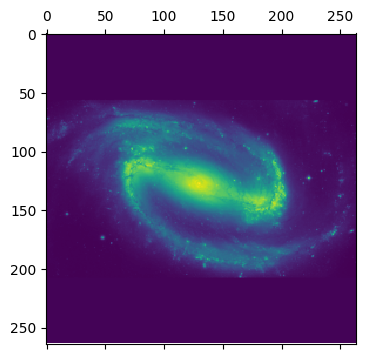

11476 number of coefficients
(264, 264)


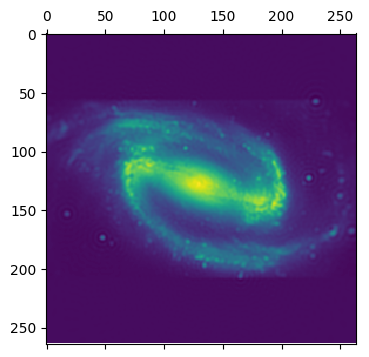

In [4]:
# import NGC1300 jpg image and decompose it

path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
ngc_filename = os.path.join(module_path, 'Data/Galaxies/ngc1300.jpg')

ngc_data = scipy.ndimage.imread(ngc_filename, flatten=True, mode=None)
median = np.median(ngc_data[:200, :200])
ngc_data -= median
print(median)


nx, ny = np.shape(ngc_data)
n_min = min(nx, ny)
n_max = max(nx, ny)
print n_max
ngc_new = np.zeros((n_max, n_max))
x_start = int((n_max - nx)/2.)
y_start = int((n_max - ny)/2.)
ngc_new[x_start:x_start+nx, y_start:y_start+ny] = ngc_data

plt.matshow(ngc_new)
plt.show()
sigma = 5
ngc_new = scipy.ndimage.filters.gaussian_filter(ngc_new, sigma, mode='nearest', truncate=6)
plt.matshow(ngc_new)
plt.show()

factor = 25  # lower resolution of image with a given factor
numPix_large = len(ngc_new)/factor
print(numPix_large)
print numPix_large * factor - n_max
n_new = (numPix_large-1)*factor
ngc_cut = ngc_new[0:n_new,0:n_new]
x, y = util.make_grid(numPix=numPix_large-1, deltapix=1)  # make a coordinate grid
ngc_data_resized = image_util.re_size(ngc_cut, factor)  # re-size image to lower resolution
#
#print(ngc_data_resized[5500:5560, 1990:2000])
#print('median: ', median)
ngc_data_resized -= 0# median  # subtract a "background" value
plt.matshow(ngc_data_resized)
plt.show()

image_1d = util.image2array(ngc_data_resized)  # map 2d image in 1d data array

n_max = 150  # choice of number of shapelet basis functions, 150 is a high resolution number, but takes long
beta = 10  # shapelet scale parameter

# return the shapelet coefficients
param_list_ngc = shapeletSet.decomposition(image_1d, x, y, n_max, beta, 1., center_x=0, center_y=0) 
print len(param_list_ngc), 'number of coefficients'  # number of coefficients

# reconstruct M31 with the shapelet coefficients
image_reconstructed = shapeletSet.function(x, y, param_list_ngc, n_max, beta, center_x=0, center_y=0)
image_reconstructed_2d = util.array2image(image_reconstructed)  # map 1d data vector in 2d image


print(image_reconstructed_2d.shape)
plt.matshow(image_reconstructed_2d)
plt.show()

## simulation illustration with lenstronomy ImSim API

In [5]:
# import main simulation class of lenstronomy

# data specifics
background_rms = 10.  #  background noise per pixel
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 64  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
high_res_factor = 5
subgrid_res = high_res_factor
fwhm = 0.1 # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'gaussian', 'pixel', 'NONE'



lens_model_list = ['SPEP', 'SHEAR']
kwargs_spemd = {'theta_E': 0.5, 'gamma': 2., 'center_x':0, 'center_y': 0, 'q': 1., 'phi_G': 0.2}
kwargs_shear = {'e1': 0.0, 'e2': 0.0}
kwargs_lens = [kwargs_spemd, kwargs_shear]

source_x = 0.2
source_y = 0.

beta_model = 0.06
param_list = param_list_ngc
kwargs_shapelet = {'n_max': n_max, 'beta': beta_model, 'amp': param_list, 'center_x': source_x, 'center_y': source_y}
source_model_list = ['SHAPELETS']
kwargs_source = [kwargs_shapelet]

lens_light_model_list = ['NONE']
kwargs_lens_light = [{}]

from lenstronomy.LensModel.lens_model import LensModel
lensModel = LensModel(lens_model_list)

from lenstronomy.LightModel.light_model import LightModel
sourceLightModel = LightModel(source_model_list)


In [6]:
# real lensed image
from lenstronomy.SimulationAPI.simulations import Simulation
SimAPI = Simulation()
data_real = SimAPI.data_configure(numPix, deltaPix, exp_time, background_rms)
data_high_res = SimAPI.data_configure(numPix*high_res_factor, deltaPix/high_res_factor, exp_time, background_rms)
psf = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=31, deltaPix=deltaPix, truncate=20, kernel=None)
psf_high_res = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=31, deltaPix=deltaPix/high_res_factor, truncate=6, kernel=None)
psf_no = SimAPI.psf_configure(psf_type='NONE')
kwargs_numerics = {'subgrid_res': subgrid_res, 'psf_subgrid': True}


from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class=data_real, psf_class=psf_no, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_lensed = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

imageModel = ImageModel(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_no_noise_lensed = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

poisson = image_util.add_poisson(image_no_noise_lensed, exp_time=exp_time)
bkg = image_util.add_background(image_no_noise_lensed, sigma_bkd=background_rms)
image_real_lensed = image_no_noise_lensed + poisson + bkg

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_high_res, kwargs_numerics={}, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_high_res_conv_lensed = imageModel_high_res.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

imageModel_high_res = ImageModel(data_class=data_high_res, psf_class=psf_no, kwargs_numerics={}, lens_model_class=lensModel, source_model_class=sourceLightModel)
image_high_res_lensed = imageModel_high_res.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

imageModel_ = ImageModel(data_class=data_high_res, psf_class=psf_no, kwargs_numerics={}, source_model_class=sourceLightModel)
image_high_res_nolens_large = imageModel_.image(kwargs_lens=None, kwargs_source=kwargs_source, kwargs_lens_light=None, kwargs_ps=None)

#image_real_lensed = SimAPI.im_sim(kwargs_options, kwargs_data_real, kwargs_psf, kwargs_lens_list, kwargs_source_list, kwargs_lens_light_list, kwargs_else)
#image_no_noise_lensed = SimAPI.im_sim(kwargs_options, kwargs_data_real, kwargs_psf, kwargs_lens_list, kwargs_source_list, kwargs_lens_light_list, kwargs_else, no_noise=True)
#image_high_res_conv_lensed = SimAPI.im_sim(kwargs_options_high_res, kwargs_data_high_res, kwargs_psf_high_res, kwargs_lens_list, kwargs_source_list, kwargs_lens_light_list, kwargs_else, no_noise=True)
#image_high_res_lensed = SimAPI.im_sim(kwargs_options_high_res, kwargs_data_high_res, kwargs_psf_no, kwargs_lens_list, kwargs_source_list, kwargs_lens_light_list, kwargs_else, no_noise=True)
#image_lensed = SimAPI.im_sim(kwargs_options, kwargs_data_real, kwargs_psf_no, kwargs_lens_list, kwargs_source_list, kwargs_lens_light_list, kwargs_else, no_noise=True)




In [7]:
# profiling routine

#%load_ext line_profiler
# real lensed image
#kwargs_data_real = SimAPI.data_configure(numPix, deltaPix, exp_time, sigma_bkg)
#kwargs_data_high_res = SimAPI.data_configure(numPix*high_res_factor, deltaPix/high_res_factor, exp_time, sigma_bkg)
#kwargs_psf = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=31, deltaPix=deltaPix, truncate=3, kernel=None)
#kwargs_psf_high_res = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=31, deltaPix=deltaPix/high_res_factor, truncate=3, kernel=None)



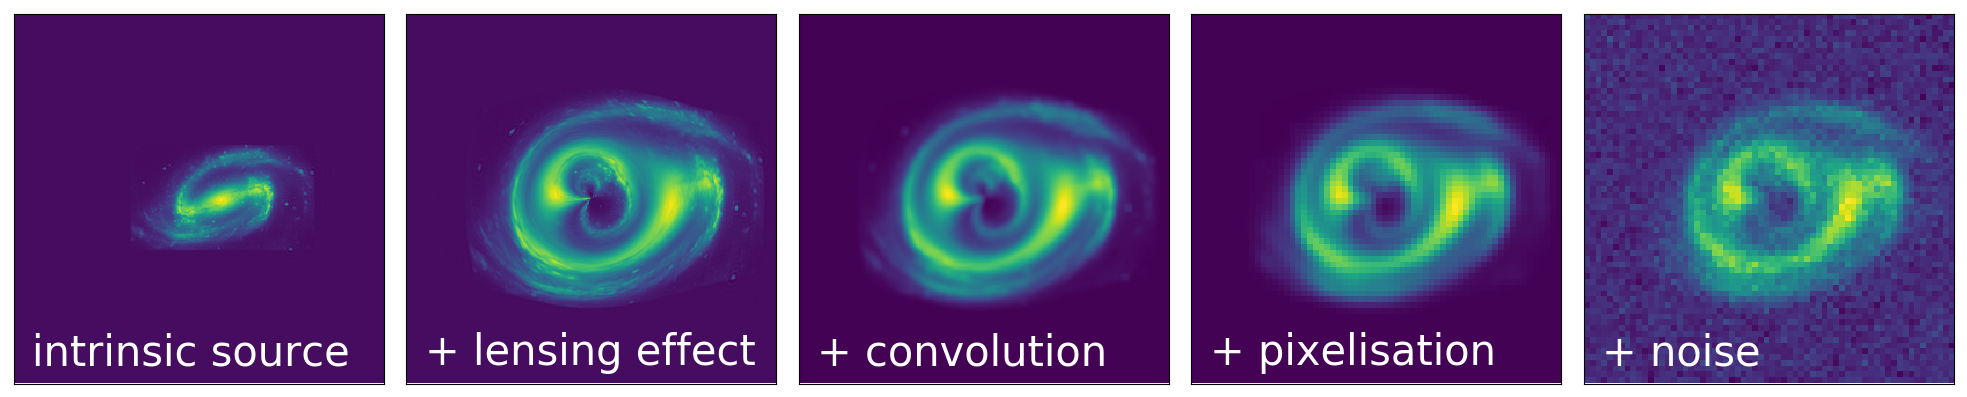

In [8]:
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = 0
v_max = 2

f, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=False, sharey=False)


# sequence of strong lensing + shear
i = 0

ax = axes[0]
im = ax.matshow((image_high_res_nolens_large), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
    
ax = axes[1]
im = ax.matshow((image_high_res_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[2]
im = ax.matshow((image_high_res_conv_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[3]
im = ax.matshow((image_no_noise_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

ax = axes[4]
im = ax.matshow((image_real_lensed), origin='lower', extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)


i = 0
ax = axes[0]
x_pos, y_pos = 0.05, 0.05
fontsize_description = 30
ax.text(x_pos, y_pos, "intrinsic source", color="w", fontsize=fontsize_description)
ax = axes[1]
ax.text(x_pos, y_pos, "+ lensing effect", color="w", fontsize=fontsize_description)
ax = axes[2]
ax.text(x_pos, y_pos, "+ convolution", color="w", fontsize=fontsize_description)
ax = axes[3]
ax.text(x_pos, y_pos, "+ pixelisation", color="w", fontsize=fontsize_description)
ax = axes[4]
ax.text(x_pos, y_pos, "+ noise", color="w", fontsize=fontsize_description)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.savefig('/Users/sibirrer/Cosmology/Strong_Lensing/Papers/Lenstronomy/LenstronomyPaper/simAPI.pdf', format='pdf')
plt.show()

# lenstronomy shapelet reconstruction

In [9]:
data_real.update_data(image_real_lensed)
imageModel = ImageModel(data_class=data_real, psf_class=psf, kwargs_numerics=kwargs_numerics, lens_model_class=lensModel, source_model_class=sourceLightModel)

In [10]:
kwargs_lens= [kwargs_spemd, kwargs_shear]  # we use the same lens model to reconstruct the image
n_max_reconstruct = 25 # we can change the source basis set order (we acctually have to do it due to the finite pixel resolution and psf)
beta_reconstruct = 0.15  # scaling can also be adopted
kwargs_source = [{'n_max': n_max_reconstruct, 'center_x': source_x, 'center_y': source_y, 'beta': beta_reconstruct}]

# this is the linear inversion
wls_model, _, cov_param, param = imageModel.image_linear_solve(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None, inv_bool=False)
lensed_reconstructed = wls_model

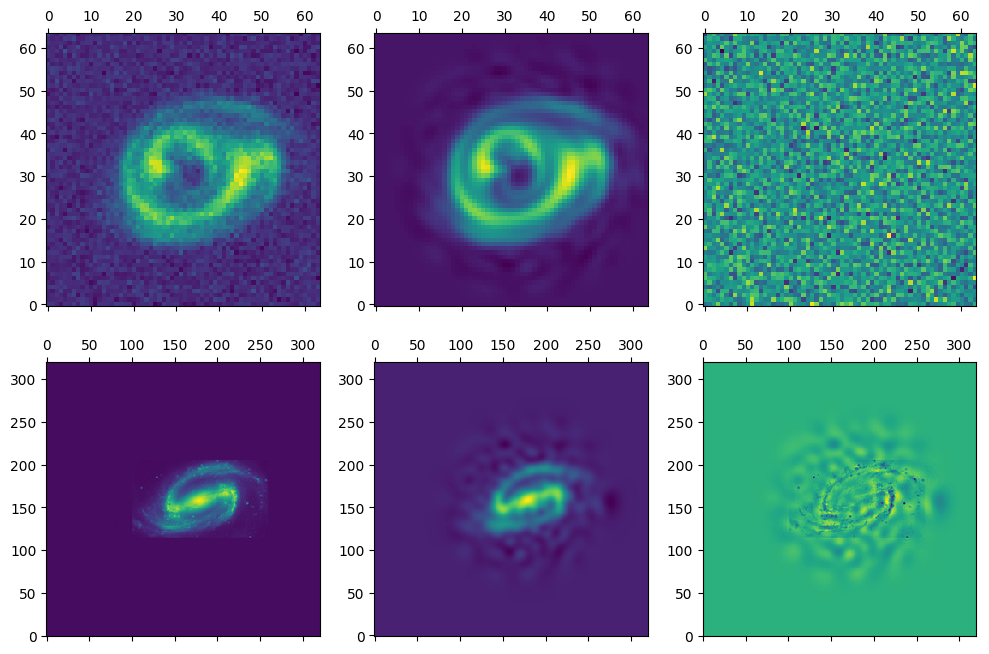

In [11]:
# given the solution of the linear inversion, we can also plot the coefficients in the source plane
x_coords, y_coords = data_high_res.coordinates
source_reconstructed = shapeletSet.function(x_coords, y_coords, param, n_max_reconstruct, beta_reconstruct, center_x=source_x, center_y=source_y)
source_reconstructed_2d = util.array2image(source_reconstructed)  # map 1d data vector in 2d image


f, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=False, sharey=False)

axes[0,0].matshow(image_real_lensed, origin='lower')
axes[0,1].matshow(wls_model, origin='lower')
# and here the reduced residuals
reduced_residuals = imageModel.reduced_residuals(wls_model)
axes[0,2].matshow(reduced_residuals, origin='lower')

axes[1,0].matshow(image_high_res_nolens_large, origin='lower')
axes[1,1].matshow(source_reconstructed_2d, origin='lower')
# and here the residuals relative to the true input source
axes[1,2].matshow(source_reconstructed_2d - image_high_res_nolens_large, origin='lower')

plt.show()
